# Tied Embeddings: Why Sharing Weights Isn't Always Principled

In transformers, we have two matrices that deal with tokens:
- **Embedding matrix** $W_E$: converts tokens → vectors (input)
- **Unembedding matrix** $W_U$: converts residual stream → logits (output)

**Tied embeddings** means using the same weights: $W_U = W_E^T$

This seems elegant. Fewer parameters, shared structure. But there's a fundamental mathematical problem with this.

This notebook will show you exactly what that problem is, with concrete numbers.


In [28]:

import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)
plt.rcParams['figure.figsize'] = (10, 4)


import sys
from pathlib import Path

# Add workspace root to Python path so we can import silen_lib
workspace_root = Path.cwd().parent.parent
if str(workspace_root) not in sys.path:
    sys.path.insert(0, str(workspace_root))

import silen_lib.utils as utils

utils.set_seed(42)

## Setup: A Toy Vocabulary

Let's work with a tiny vocabulary of 3 tokens to make everything concrete:


In [3]:
# | setup-vocab inline expanded
# Our tiny vocabulary
vocab = ["New", "York", "City"]
vocab_size = len(vocab)

# Create a mapping
token_to_id = {token: i for i, token in enumerate(vocab)}
id_to_token = {i: token for i, token in enumerate(vocab)}

print("Vocabulary:")
for token, idx in token_to_id.items():
    print(f"  '{token}' → index {idx}")


Vocabulary:
  'New' → index 0
  'York' → index 1
  'City' → index 2


In [29]:
# | one-hot-vectors inline expanded
# Tokens are represented as one-hot vectors
def one_hot(token_id, vocab_size):
    vec = np.zeros(vocab_size)
    vec[token_id] = 1.0
    return vec

# Show one-hot representations
print("One-hot representations:")
for token, idx in token_to_id.items():
    print(f"  '{token}': {one_hot(idx, vocab_size)}")


One-hot representations:
  'New': [1. 0. 0.]
  'York': [0. 1. 0.]
  'City': [0. 0. 1.]


## The Embedding Matrix

The embedding matrix $W_E$ converts one-hot vectors into dense embedding vectors.

Each row of $W_E$ is the embedding for one token.


In [5]:
# | embedding-matrix inline expanded
# Create an embedding matrix (vocab_size × embedding_dim)
# Let's use 2D embeddings so we can visualize them
embedding_dim = 2

# Each row is the embedding for a token
W_E = np.array([
    [1.0, 0.5],   # "New"  - row 0
    [0.8, 0.9],   # "York" - row 1
    [0.3, 1.2],   # "City" - row 2
])

print("Embedding matrix W_E (shape: vocab_size × embedding_dim):")
print(W_E)
print(f"\nShape: {W_E.shape}")


Embedding matrix W_E (shape: vocab_size × embedding_dim):
[[1.  0.5]
 [0.8 0.9]
 [0.3 1.2]]

Shape: (3, 2)


In [6]:
# | get-embedding inline expanded
# To get a token's embedding: multiply one-hot vector by W_E
# This just selects the corresponding row

token = "York"
token_id = token_to_id[token]
token_onehot = one_hot(token_id, vocab_size)

embedding = token_onehot @ W_E

print(f"Token: '{token}'")
print(f"One-hot: {token_onehot}")
print(f"Embedding = one_hot @ W_E = {embedding}")
print(f"\n(This is just row {token_id} of W_E: {W_E[token_id]})")


Token: 'York'
One-hot: [0. 1. 0.]
Embedding = one_hot @ W_E = [0.8 0.9]

(This is just row 1 of W_E: [0.8 0.9])


## The Unembedding Matrix

At the output, we need to convert the residual stream (a vector) back to logits (one score per token).

The **unembedding matrix** $W_U$ does this: `logits = residual @ W_U`

With **tied embeddings**, we reuse the embedding matrix: $W_U = W_E^T$


In [7]:
# | unembedding inline expanded
# With TIED embeddings: W_U = W_E transposed
W_U_tied = W_E.T

print("Embedding matrix W_E:")
print(W_E)
print(f"Shape: {W_E.shape}")

print("\nTied unembedding W_U = W_E^T:")
print(W_U_tied)
print(f"Shape: {W_U_tied.shape}")


Embedding matrix W_E:
[[1.  0.5]
 [0.8 0.9]
 [0.3 1.2]]
Shape: (3, 2)

Tied unembedding W_U = W_E^T:
[[1.  0.8 0.3]
 [0.5 0.9 1.2]]
Shape: (2, 3)


In [12]:
# | compute-logits inline expanded
# How unembedding works: residual vector → logits
# Each logit is the dot product of residual with a token's embedding

residual = np.array([0.3, 2.3])  # some output from the model

# With tied embeddings: logits = residual @ W_E^T
# This is equivalent to: dot product of residual with each embedding row
logits = residual @ W_U_tied

print(f"Residual vector: {residual}")
print(f"\nLogits = residual @ W_U:")
for i, token in enumerate(vocab):
    dot = np.dot(residual, W_E[i])
    print(f"  logit for '{token}': {residual} · {W_E[i]} = {dot:.3f}")

print(f"\nLogits vector: {logits}")

# Let's also compute the softmax over the logits to get output probabilities - how it would be done in a real model
def softmax(x):
    exp_x = np.exp(x - np.max(x))  # for numerical stability
    return exp_x / np.sum(exp_x)

probs = softmax(logits)
print(f"\nSoftmax (probabilities) over logits:")
for token, p in zip(vocab, probs):
    print(f"  P('{token}') = {p:.4f}")



Residual vector: [0.3 2.3]

Logits = residual @ W_U:
  logit for 'New': [0.3 2.3] · [1.  0.5] = 1.450
  logit for 'York': [0.3 2.3] · [0.8 0.9] = 2.310
  logit for 'City': [0.3 2.3] · [0.3 1.2] = 2.850

Logits vector: [1.45 2.31 2.85]

Softmax (probabilities) over logits:
  P('New') = 0.1348
  P('York') = 0.3186
  P('City') = 0.5466


## The "Direct Path"

In a transformer, information flows through attention and MLP layers. But because of **residual connections**, there's always a direct linear path from input to output:

```
token (one-hot) → W_E → [residual stream] → W_U → logits
```

Even in a deep model, this path exists. If we ignore all the attention/MLP layers, the model computes:

$$\text{logits} = \text{one\_hot} \cdot W_E \cdot W_U$$

What does this direct path want to learn?


![High-level diagram of a transformer](../assets/high-level-transformer.png)


In [13]:
# | direct-path-matrix inline expanded
# The direct path is: one_hot @ W_E @ W_U
# Let's compute W_E @ W_U - this is the "direct path matrix"

direct_path_tied = W_E @ W_U_tied

print("Direct path matrix (W_E @ W_U) with TIED embeddings:")
print(direct_path_tied)
print(f"\nShape: {direct_path_tied.shape} (vocab_size × vocab_size)")


Direct path matrix (W_E @ W_U) with TIED embeddings:
[[1.25 1.25 0.9 ]
 [1.25 1.45 1.32]
 [0.9  1.32 1.53]]

Shape: (3, 3) (vocab_size × vocab_size)


In [14]:
# | direct-path-meaning inline expanded
# This matrix tells us: given input token i, what are the logits for each output token j?
# Entry [i, j] = logit score for predicting token j when input is token i

print("What the direct path matrix means:")
print("Entry [i,j] = logit for output token j, given input token i\n")

for i, input_token in enumerate(vocab):
    print(f"If input = '{input_token}':")
    logits = direct_path_tied[i]
    for j, output_token in enumerate(vocab):
        print(f"    logit for '{output_token}': {logits[j]:.3f}")
    print()


What the direct path matrix means:
Entry [i,j] = logit for output token j, given input token i

If input = 'New':
    logit for 'New': 1.250
    logit for 'York': 1.250
    logit for 'City': 0.900

If input = 'York':
    logit for 'New': 1.250
    logit for 'York': 1.450
    logit for 'City': 1.320

If input = 'City':
    logit for 'New': 0.900
    logit for 'York': 1.320
    logit for 'City': 1.530



## What Should the Direct Path Learn?

If the model had **no attention or MLP layers**, the only thing it could learn is:

> "Given the current token, what's the most likely next token?"

This boils down to **bigram statistics**: how often each possible pair of tokens appears in sequence in the training data.

More precisely, a "bigram" is any two consecutive tokens ("token₁", "token₂") in text. 

The bigram statistics are usually stored as a matrix or table of conditional probabilities:

> P(next_token | current_token)

which tells us, given a current token, what is the probability that each possible next token will follow.

For instance, in the phrase "New York City," "New York" and "York City" are two bigrams—each represents a pair of adjacent tokens.

Let's look at realistic bigram statistics for our vocabulary:


In [30]:
# | bigram-matrix inline expanded
# Realistic bigram probabilities for "New", "York", "City"
# P(next | current)

# Think about real language:
# - "New York" is very common → P(York | New) is high
# - "York New" is rare → P(New | York) is low
# - "New City" is less common than "New York"
# - "York City" is common (as in "New York City")

# Let's use realistic probabilities:
bigram_probs = np.array([
    # next:  New   York   City
    [0.05,  0.85,  0.10],  # current = "New"  → "York" most likely, "New" repetition rare
    [0.10,  0.05,  0.85],  # current = "York" → "City" most likely, repetition rare  
    [0.60,  0.30,  0.10],  # current = "City" → new phrase likely, "City" repetition rare
])

print("Bigram probability matrix P(next | current):")
print("Diagonal entries [i, i] show P(repeat | token). Usually NOT 1 or 0.")
print("Rows = current token, Columns = next token\n")

print("         ", end="")
for token in vocab:
    print(f"{token:>8}", end="")
print()

for i, current in enumerate(vocab):
    print(f"{current:>8} ", end="")
    for j, next_token in enumerate(vocab):
        print(f"{bigram_probs[i,j]:>8.2f}", end="")
    print()


Bigram probability matrix P(next | current):
Diagonal entries [i, i] show P(repeat | token). Usually NOT 1 or 0.
Rows = current token, Columns = next token

              New    York    City
     New     0.05    0.85    0.10
    York     0.10    0.05    0.85
    City     0.60    0.30    0.10


In [31]:
# | bigram-asymmetry inline expanded
# THE KEY POINT: Bigrams are ASYMMETRIC
# P(York | New) ≠ P(New | York)

print("CRITICAL OBSERVATION: Bigrams are ASYMMETRIC\n")

print(f"P(York | New) = {bigram_probs[0, 1]:.2f}  ← 'New York' is common")
print(f"P(New | York) = {bigram_probs[1, 0]:.2f}  ← 'York New' is rare")
print()
print(f"P(City | York) = {bigram_probs[1, 2]:.2f}  ← 'York City' is common")
print(f"P(York | City) = {bigram_probs[2, 1]:.2f}  ← 'City York' is less common")

print("\n→ The order matters! This matrix is NOT symmetric.")


CRITICAL OBSERVATION: Bigrams are ASYMMETRIC

P(York | New) = 0.85  ← 'New York' is common
P(New | York) = 0.10  ← 'York New' is rare

P(City | York) = 0.85  ← 'York City' is common
P(York | City) = 0.30  ← 'City York' is less common

→ The order matters! This matrix is NOT symmetric.


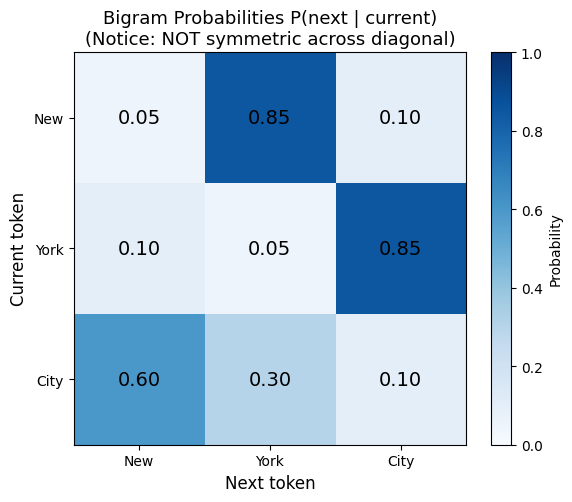

In [ ]:
# | bigram-visualization inline
# Visualize the bigram matrix
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(bigram_probs, cmap='Blues', vmin=0, vmax=1)

# Add text annotations
for i in range(len(vocab)):
    for j in range(len(vocab)):
        ax.text(j, i, f'{bigram_probs[i, j]:.2f}', ha='center', va='center', fontsize=14)

ax.set_xticks(range(len(vocab)))
ax.set_yticks(range(len(vocab)))
ax.set_xticklabels(vocab)
ax.set_yticklabels(vocab)
ax.set_xlabel('Next token', fontsize=12)
ax.set_ylabel('Current token', fontsize=12)
ax.set_title('Bigram Probabilities P(next | current)\n(Notice: NOT symmetric across diagonal)', fontsize=13)
plt.colorbar(im, label='Probability')
plt.tight_layout()
plt.show()


## The Problem: Tied Embeddings Force Symmetry

Now here's the critical issue. With tied embeddings:

$$W_U = W_E^T$$

So the direct path matrix becomes:

$$W_E \cdot W_U = W_E \cdot W_E^T$$

Let's see what this produces:


In [21]:
# | tied-result inline expanded
# Compute W_E @ W_E^T
direct_path_tied = W_E @ W_E.T

print("W_E:")
print(W_E)
print("\nW_E^T:")
print(W_E.T)
print("\nDirect path matrix W_E @ W_E^T:")
print(direct_path_tied)


W_E:
[[1.  0.5]
 [0.8 0.9]
 [0.3 1.2]]

W_E^T:
[[1.  0.8 0.3]
 [0.5 0.9 1.2]]

Direct path matrix W_E @ W_E^T:
[[1.25 1.25 0.9 ]
 [1.25 1.45 1.32]
 [0.9  1.32 1.53]]


In [22]:
# | symmetry-check inline expanded
# Check: is W_E @ W_E^T symmetric?
print("Is W_E @ W_E^T symmetric?")
print()
print(f"Entry [New, York]  = {direct_path_tied[0, 1]:.3f}")
print(f"Entry [York, New]  = {direct_path_tied[1, 0]:.3f}")
print()
print(f"Entry [York, City] = {direct_path_tied[1, 2]:.3f}")  
print(f"Entry [City, York] = {direct_path_tied[2, 1]:.3f}")
print()
print("→ YES! They're exactly equal. The matrix is ALWAYS symmetric.")


Is W_E @ W_E^T symmetric?

Entry [New, York]  = 1.250
Entry [York, New]  = 1.250

Entry [York, City] = 1.320
Entry [City, York] = 1.320

→ YES! They're exactly equal. The matrix is ALWAYS symmetric.


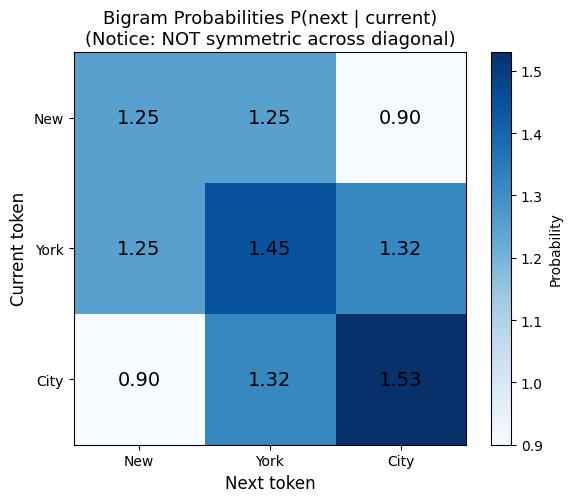

In [ ]:
# | tied-visualization inline
# Visualize the bigram matrix
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(direct_path_tied, cmap='Blues')

# Add text annotations
for i in range(len(vocab)):
    for j in range(len(vocab)):
        ax.text(j, i, f'{direct_path_tied[i, j]:.2f}', ha='center', va='center', fontsize=14)

ax.set_xticks(range(len(vocab)))
ax.set_yticks(range(len(vocab)))
ax.set_xticklabels(vocab)
ax.set_yticklabels(vocab)
ax.set_xlabel('Next token', fontsize=12)
ax.set_ylabel('Current token', fontsize=12)
ax.set_title('Bigram Probabilities P(next | current)\n(Notice: NOT symmetric across diagonal)', fontsize=13)
plt.colorbar(im, label='Probability')
plt.tight_layout()
plt.show()


### Why is $W_E \cdot W_E^T$ Always Symmetric?

This is linear algebra:

$$(W_E \cdot W_E^T)_{ij} = \text{row}_i(W_E) \cdot \text{row}_j(W_E) = \text{embedding}_i \cdot \text{embedding}_j$$

And dot products are commutative: $a \cdot b = b \cdot a$

So:
$$(W_E \cdot W_E^T)_{ij} = (W_E \cdot W_E^T)_{ji}$$

**No matter what values $W_E$ has, $W_E \cdot W_E^T$ is always symmetric which means that the model will learn the same probability for "New York" and "York New".**

A token embedding vector needs to encode:

- syntactic type (noun/verb/etc)
- morphology    
- semantics
- style
- discourse-level properties                
- downstream attentional compatibility
- positional modulations (via RoPE)

Whereas a logit vector needs to encode:

- “what token would be plausible to emit now?”
- context-dependent predictive distribution
- grammar
- topic flow
- memorized facts   

## Why Doesn't SGD Fix This?
 
You might wonder: "Sure, but SGD is powerful, it can try to find embeddings such that $W_E \cdot W_E^T$ captures both semantic meaning and matches the bigram probabilities on the output side, right?"
 
While SGD does its best to optimize $W_E$ so that $W_E \cdot W_E^T$ fits the data, it's fundamentally limited: this product is always constrained to be symmetric, so it simply can't faithfully reproduce real-world bigram matrices, which are typically asymmetric. This limitation forces the model to compromise, trying to encode both meaning and the predictive distribution using the same parameters. 
 
As a result, the suboptimality of this approach becomes more pronounced as models scale up.
 
Let's try different embedding matrices and observe that the result is ALWAYS symmetric:


In [33]:
# | random-matrices inline expanded
# Let's try random embedding matrices and check if W_E @ W_E^T is ever asymmetric
print("Trying different random embedding matrices:\n")

for trial in range(4):
    W_random = np.random.randn(3, 2)
    product = W_random @ W_random.T
    
    # Check symmetry
    is_symmetric = np.allclose(product, product.T)
    
    print(f"Trial {trial + 1}:")
    print(f"  W_E @ W_E^T =")
    print(f"  {product[0]}")
    print(f"  {product[1]}")
    print(f"  {product[2]}")
    print(f"  Symmetric? {is_symmetric}")
    print()

print("→ No matter what W_E we choose, W_E @ W_E^T is ALWAYS symmetric!")
print("  This is a mathematical fact, not something SGD can change.")


Trying different random embedding matrices:

Trial 1:
  W_E @ W_E^T =
  [ 0.266  0.111 -0.084]
  [ 0.111  2.739 -0.508]
  [-0.084 -0.508  0.11 ]
  Symmetric? True

Trial 2:
  W_E @ W_E^T =
  [ 3.083 -0.325 -1.089]
  [-0.325  0.515 -0.035]
  [-1.089 -0.035  0.432]
  Symmetric? True

Trial 3:
  W_E @ W_E^T =
  [ 3.719  0.658 -0.846]
  [0.658 3.292 1.57 ]
  [-0.846  1.57   1.125]
  Symmetric? True

Trial 4:
  W_E @ W_E^T =
  [ 2.819 -1.012  1.951]
  [-1.012  2.199  0.421]
  [1.951 0.421 2.034]
  Symmetric? True

→ No matter what W_E we choose, W_E @ W_E^T is ALWAYS symmetric!
  This is a mathematical fact, not something SGD can change.


## What About Untied Embeddings?

With **untied embeddings**, $W_U$ is a separate learnable matrix. Now the direct path is:

$$W_E \cdot W_U$$

where $W_E$ and $W_U$ are independent matrices. Let's see what this allows:


In [34]:
# | untied-matrix inline expanded
# With UNTIED embeddings: W_U is a separate matrix
# Now W_E @ W_U can be ANY matrix (including asymmetric ones)

# Let's create a W_U that, combined with W_E, approximates our bigram matrix
# We want: W_E @ W_U ≈ bigram_probs

# One way: solve for W_U = W_E^(-1) @ bigram_probs (pseudo-inverse)
W_E_pinv = np.linalg.pinv(W_E)
W_U_untied = W_E_pinv @ bigram_probs

print("Untied unembedding matrix W_U:")
print(W_U_untied)
print(f"\nShape: {W_U_untied.shape}")


Untied unembedding matrix W_U:
[[-0.298  0.623  0.3  ]
 [ 0.522 -0.062  0.185]]

Shape: (2, 3)


In [35]:
# | untied-result inline expanded
# Now compute the direct path with untied embeddings
direct_path_untied = W_E @ W_U_untied

print("Direct path matrix W_E @ W_U (UNTIED):")
print(direct_path_untied.round(3))

print("\nOriginal bigram matrix (what we want):")
print(bigram_probs)

print("\n→ With untied embeddings, we CAN approximate asymmetric bigrams!")


Direct path matrix W_E @ W_U (UNTIED):
[[-0.037  0.592  0.392]
 [ 0.232  0.443  0.406]
 [ 0.537  0.113  0.312]]

Original bigram matrix (what we want):
[[0.05 0.85 0.1 ]
 [0.1  0.05 0.85]
 [0.6  0.3  0.1 ]]

→ With untied embeddings, we CAN approximate asymmetric bigrams!


In [36]:
# | can-represent-asymmetric inline expanded
# The key comparison: can we represent "New→York" ≠ "York→New"?

print("Can we represent asymmetric relationships?\n")

print("TIED embeddings (W_E @ W_E^T):")
print(f"  [New, York] = {direct_path_tied[0, 1]:.3f}")
print(f"  [York, New] = {direct_path_tied[1, 0]:.3f}")
print(f"  Equal? {np.isclose(direct_path_tied[0, 1], direct_path_tied[1, 0])} ← FORCED to be equal!")

print("\nUNTIED embeddings (W_E @ W_U):")
print(f"  [New, York] = {direct_path_untied[0, 1]:.3f}")
print(f"  [York, New] = {direct_path_untied[1, 0]:.3f}")  
print(f"  Equal? {np.isclose(direct_path_untied[0, 1], direct_path_untied[1, 0])} ← Can be different!")

print("\nTarget (real bigrams):")
print(f"  P(York|New) = {bigram_probs[0, 1]:.2f}")
print(f"  P(New|York) = {bigram_probs[1, 0]:.2f}")


Can we represent asymmetric relationships?

TIED embeddings (W_E @ W_E^T):
  [New, York] = 1.250
  [York, New] = 1.250
  Equal? True ← FORCED to be equal!

UNTIED embeddings (W_E @ W_U):
  [New, York] = 0.592
  [York, New] = 0.232
  Equal? False ← Can be different!

Target (real bigrams):
  P(York|New) = 0.85
  P(New|York) = 0.10


## How Do Small Models Work Around This?

If tied embeddings have this fundamental limitation, why do smaller models (<8B parameters) still use them?

**Answer**: The first MLP layer (MLP0) can "break the symmetry."

Instead of the direct path being just $W_E \cdot W_E^T$, it becomes:

$$W_E \rightarrow \text{MLP}_0 \rightarrow \text{residual} \rightarrow W_E^T$$

MLP0 can learn a transformation that compensates for the forced symmetry.


In [37]:
# | mlp-breaks-symmetry inline expanded
# Simulate how MLP0 can break symmetry
# MLP0 transforms the embedding before it goes to the unembedding

# A simple MLP: linear transformation (in practice it has nonlinearity too)
# MLP0: embedding_dim → embedding_dim

# If we learn: residual = embedding @ M (where M is the MLP weight)
# Then the path becomes: one_hot @ W_E @ M @ W_E^T
# And W_E @ M @ W_E^T is NOT necessarily symmetric!

M_mlp = np.array([
    [1.2, -0.3],
    [0.5,  0.8]
])

# New path: W_E @ M @ W_E^T
path_with_mlp = W_E @ M_mlp @ W_E.T

print("MLP transformation matrix M:")
print(M_mlp)

print("\nPath WITH MLP0: W_E @ M @ W_E^T")
print(path_with_mlp)

print("\nIs this symmetric?")
print(f"  [New, York] = {path_with_mlp[0, 1]:.3f}")
print(f"  [York, New] = {path_with_mlp[1, 0]:.3f}")
print(f"  Equal? {np.isclose(path_with_mlp[0, 1], path_with_mlp[1, 0])}")

print("\n→ MLP0 can break the symmetry! But this uses extra capacity.")


MLP transformation matrix M:
[[ 1.2 -0.3]
 [ 0.5  0.8]]

Path WITH MLP0: W_E @ M @ W_E^T
[[1.5   1.25  0.555]
 [1.65  1.56  0.999]
 [1.395 1.551 1.332]]

Is this symmetric?
  [New, York] = 1.250
  [York, New] = 1.650
  Equal? False

→ MLP0 can break the symmetry! But this uses extra capacity.


In [38]:
# | param-comparison inline expanded
# The cost: MLP0 has to "undo" the symmetry constraint
# This wastes model capacity that could be used for other things

# Compare parameter counts:
vocab_size = 3
embedding_dim = 2

tied_params = vocab_size * embedding_dim  # just W_E
untied_params = 2 * vocab_size * embedding_dim  # W_E and W_U separately

print("Parameter comparison (for our toy example):")
print(f"  Tied embeddings:   {tied_params} parameters (W_E only)")
print(f"  Untied embeddings: {untied_params} parameters (W_E + W_U)")
print(f"  Savings from tying: {untied_params - tied_params} parameters ({100*(untied_params-tied_params)/untied_params:.0f}%)")

print("\nFor a real model (vocab=50000, dim=4096):")
real_vocab, real_dim = 50000, 4096
real_tied = real_vocab * real_dim
real_untied = 2 * real_vocab * real_dim
print(f"  Tied:   {real_tied:,} parameters")
print(f"  Untied: {real_untied:,} parameters")
print(f"  Savings: {real_untied - real_tied:,} parameters ({(real_untied-real_tied)/1e6:.0f}M)")


Parameter comparison (for our toy example):
  Tied embeddings:   6 parameters (W_E only)
  Untied embeddings: 12 parameters (W_E + W_U)
  Savings from tying: 6 parameters (50%)

For a real model (vocab=50000, dim=4096):
  Tied:   204,800,000 parameters
  Untied: 409,600,000 parameters
  Savings: 204,800,000 parameters (205M)


## Summary: When to Tie, When Not to Tie

### The Core Problem

| Aspect | Tied Embeddings | Untied Embeddings |
|--------|-----------------|-------------------|
| Direct path matrix | $W_E \cdot W_E^T$ (symmetric) | $W_E \cdot W_U$ (can be asymmetric) |
| Can represent bigrams? | ❌ Not properly | ✓ Yes |
| Parameters | Fewer (share weights) | More (separate weights) |
| Memory | Less | More |

### When Tied Embeddings Work

- **Small models** (<8B parameters): MLP0 can compensate for the symmetry constraint
- **Training efficiency matters**: Fewer parameters = faster training
- **Memory constrained**: Sharing weights reduces memory footprint

### When to Use Untied Embeddings

- **Large models**: The direct path becomes more important; the symmetry constraint hurts more
- **Maximum performance**: Untied embeddings give the model more expressivity
- **State-of-the-art models**: Most large LLMs (GPT-4, Claude, etc.) use untied embeddings

### The Bottom Line

Tied embeddings are a **practical tradeoff**, not a principled design choice. They work because:
1. Small models don't rely heavily on the direct path
2. MLP0 can partially compensate for the forced symmetry
3. The parameter savings are significant

But mathematically, tying embeddings forces the direct path to be symmetric when language is fundamentally asymmetric.


/var/folders/wy/l2n7bpj15sgb25k6ylm9txkh0000gn/T/ipykernel_18318/2725117850.py:23: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/silen/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


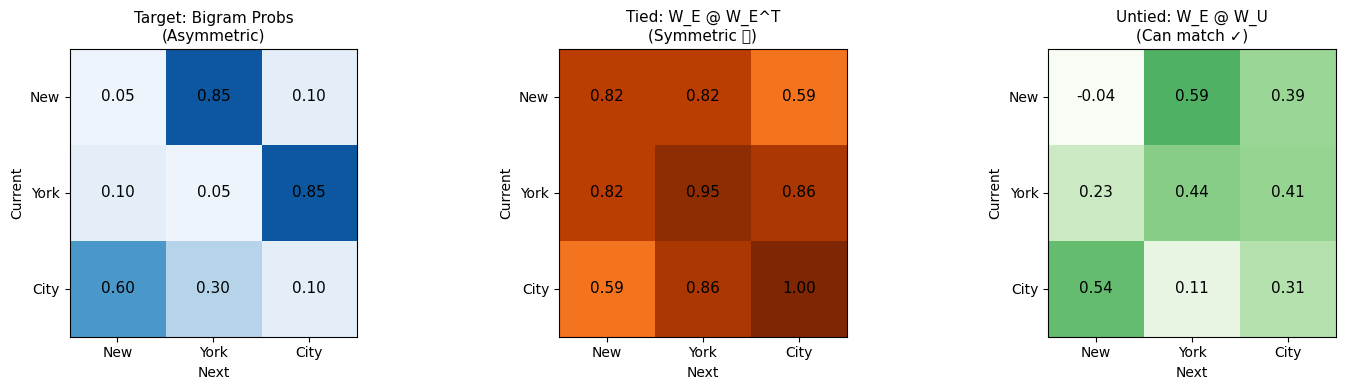

Key insight: Tied embeddings CANNOT represent 'New→York ≠ York→New'


In [ ]:
# Final visualization: side-by-side comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

matrices = [
    (bigram_probs, "Target: Bigram Probs\n(Asymmetric)", 'Blues'),
    (direct_path_tied / direct_path_tied.max(), "Tied: W_E @ W_E^T\n(Symmetric ❌)", 'Oranges'),
    (direct_path_untied, "Untied: W_E @ W_U\n(Can match ✓)", 'Greens'),
]

for ax, (matrix, title, cmap) in zip(axes, matrices):
    im = ax.imshow(matrix, cmap=cmap, vmin=0, vmax=1)
    for i in range(len(vocab)):
        for j in range(len(vocab)):
            ax.text(j, i, f'{matrix[i, j]:.2f}', ha='center', va='center', fontsize=11)
    ax.set_xticks(range(len(vocab)))
    ax.set_yticks(range(len(vocab)))
    ax.set_xticklabels(vocab, fontsize=10)
    ax.set_yticklabels(vocab, fontsize=10)
    ax.set_xlabel('Next', fontsize=10)
    ax.set_ylabel('Current', fontsize=10)
    ax.set_title(title, fontsize=11)

plt.tight_layout()
plt.show()

print("Key insight: Tied embeddings CANNOT represent 'New→York ≠ York→New'")
